<a href="https://colab.research.google.com/github/aryansrivastav15/speech-emotion-recognition/blob/main/BDA_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ JAVA_HOME set to: /usr/lib/jvm/java-17-openjdk-amd64
✅ Dataset already exists. Skipping download!
✅ Spark Session Started
⚙️ Processing Audio Files (This takes ~2 mins)...
🧠 Training Random Forest (Baseline)...
🧠 Training MLP (Deep Learning)...

📊 GENERATING REPORT VISUALIZATIONS
1. Plotting Emotion Distribution...


/tmp/ipython-input-3139136141.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="emotion", y="count", data=dist_df, palette="viridis")


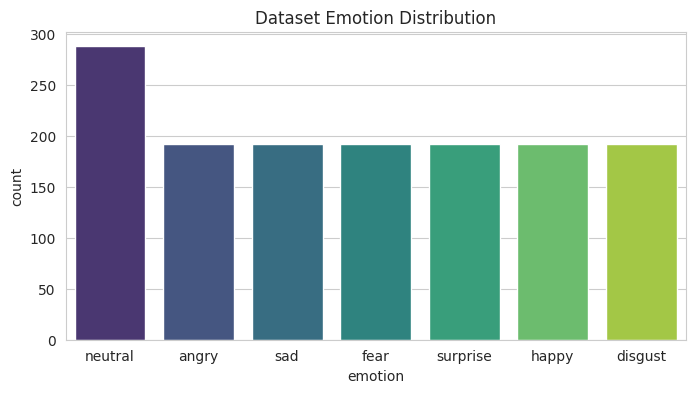


2. Calculating Performance Table...

=== Model Comparison ===


,Model,Accuracy,F1-Score
0,Random Forest,0.5680,0.5389
1,MLP (Deep Learning),0.3265,0.2523


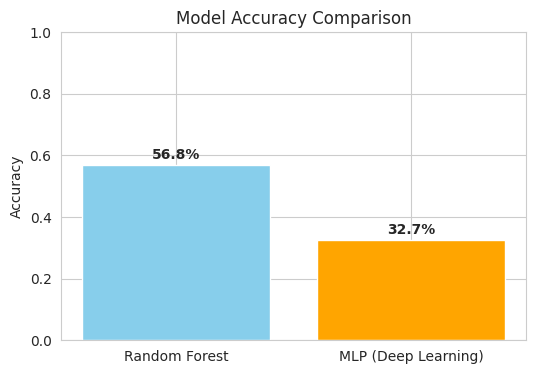


3. Generating Confusion Matrix (MLP)...


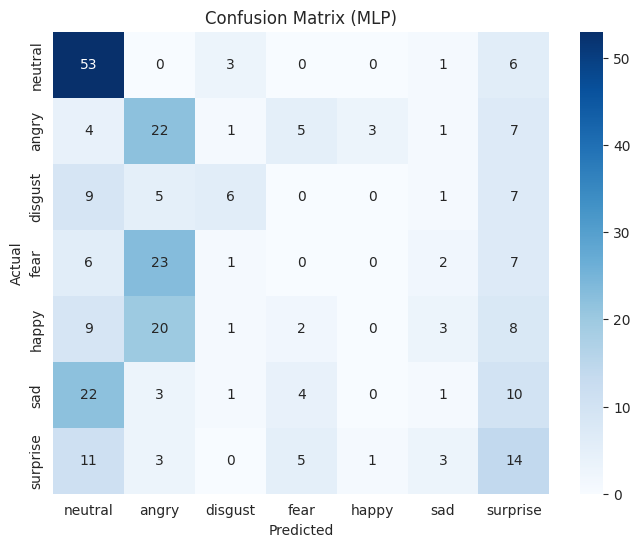


4. Feature Importance Analysis (Random Forest)...


/tmp/ipython-input-3139136141.py:197: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Feature", y="Importance", data=f_df, palette="magma")


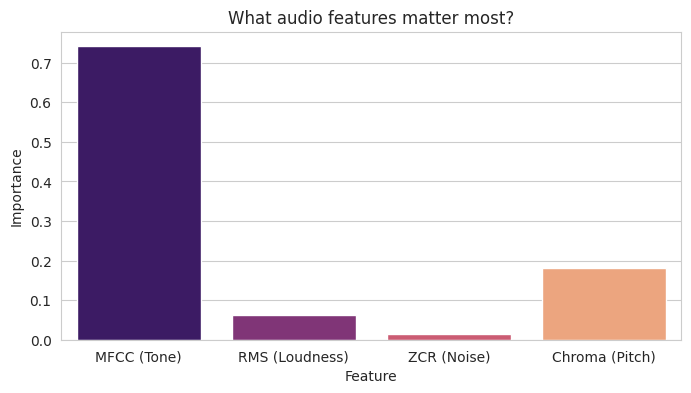


🚀 LAUNCHING INTERACTIVE WEBSITE


/usr/local/lib/python3.12/dist-packages/gradio/blocks.py:1143: UserWarning: Cannot load huggingface. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/huggingface (Request ID: Root=1-693b2c4d-4aa4b5103ede3107230f6b29;d4bc5b8d-46f1-4437-8112-87af82091559)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://eb76141942eeb6ad81.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

In [ ]:
# ==========================================
# PART 1: ROBUST SETUP & INSTALLATION
# ==========================================
import os
import subprocess
import sys

# 1. Update Linux Package Lists (Fixes 404 errors)
!apt-get update -qq

# 2. Install DEFAULT Java (Java 11) - Most stable for Colab
!apt-get install -y default-jdk-headless -qq > /dev/null

# 3. Install Python Libraries
!pip install -q pyspark librosa matplotlib seaborn numpy pandas gradio

# 4. AUTO-DETECT JAVA_HOME
try:
    java_path = subprocess.check_output(["which", "java"]).decode("utf-8").strip()
    real_path = subprocess.check_output(["readlink", "-f", java_path]).decode("utf-8").strip()
    java_home = os.path.dirname(os.path.dirname(real_path))
    os.environ["JAVA_HOME"] = java_home
    print(f"✅ JAVA_HOME set to: {java_home}")
except Exception as e:
    print(f"❌ Error detecting Java: {e}")

# ==========================================
# PART 2: SMART DATA DOWNLOAD
# ==========================================
# Optimization: Check if data exists before downloading again
data_path = "/content/data/ravdess"

if not os.path.exists(data_path) or not os.listdir(data_path):
    print("⬇️ Downloading Dataset... (1GB, this takes ~1 min)")
    !mkdir -p /content/data/ravdess
    !wget -q https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
    !unzip -o -q Audio_Speech_Actors_01-24.zip -d /content/data/ravdess
    print("✅ Data Downloaded and Unzipped")
else:
    print("✅ Dataset already exists. Skipping download!")

# ==========================================
# PART 3: SPARK PROCESSING & FEATURES
# ==========================================
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, FloatType, StringType, StructType, StructField
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import MultilayerPerceptronClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors, VectorUDT

# Initialize Spark
spark = SparkSession.builder \
    .appName("Full_SER_Project") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("✅ Spark Session Started")

# Helper: Get Label
def get_label(path):
    try:
        parts = os.path.basename(path).split("-")
        # 1=neutral, 2=calm(merged to neutral), 3=happy, 4=sad, 5=angry, 6=fear, 7=disgust, 8=surprise
        return {1:'neutral', 2:'neutral', 3:'happy', 4:'sad',
                5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}.get(int(parts[2]), 'unknown')
    except: return None

# Helper: Extract Features (MFCC, RMS, ZCR, Chroma)
def extract_features(path):
    try:
        # Load 2.5 seconds
        y, sr = librosa.load(path, duration=2.5, offset=0.5)
        target = int(2.5 * sr)
        if len(y) < target: y = np.pad(y, (0, target - len(y)))
        else: y = y[:target]

        # Extract Features
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
        rms = np.mean(librosa.feature.rms(y=y).T, axis=0)
        zcr = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        return [float(x) for x in np.hstack([mfcc, rms, zcr, chroma])]
    except: return None

# Register UDFs
label_udf = udf(get_label, StringType())
feature_udf = udf(extract_features, ArrayType(FloatType()))
to_vector = udf(lambda x: Vectors.dense(x), VectorUDT())

# Process Data
print("⚙️ Processing Audio Files (This takes ~2 mins)...")
# Using os.walk to verify files exist in the previously defined path
files = [os.path.join(r, f) for r, _, fs in os.walk(data_path) for f in fs if f.endswith('.wav')]
df = spark.createDataFrame([(f,) for f in files], ['path'])

df = df.withColumn("emotion", label_udf(col("path"))).filter(col("emotion") != "unknown")
df = df.withColumn("features_raw", feature_udf(col("path"))).dropna()
data = df.withColumn("features", to_vector("features_raw")).cache()

# Index Labels
indexer = StringIndexer(inputCol="emotion", outputCol="label")
indexed_data = indexer.fit(data).transform(data)
(train_data, test_data) = indexed_data.randomSplit([0.8, 0.2], seed=1234)

# ==========================================
# PART 4: TRAIN MODELS
# ==========================================
print("🧠 Training Random Forest (Baseline)...")
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50, maxDepth=10, seed=1234)
rf_model = rf.fit(train_data)

print("🧠 Training MLP (Deep Learning)...")
input_dim = len(train_data.select("features_raw").first()[0])
num_classes = indexed_data.select("label").distinct().count()
# Layer config: [Input, 256, 128, Output]
layers = [input_dim, 256, 128, num_classes]
mlp = MultilayerPerceptronClassifier(labelCol="label", featuresCol="features", layers=layers, blockSize=128, seed=1234, maxIter=50)
mlp_model = mlp.fit(train_data)

# ==========================================
# PART 5: VISUALIZATIONS & ANALYSIS
# ==========================================
print("\n" + "="*40)
print("📊 GENERATING REPORT VISUALIZATIONS")
print("="*40)

# Set plotting style
sns.set_style("whitegrid")

# --- A. Emotion Distribution (Page 6) ---
print("1. Plotting Emotion Distribution...")
dist_df = data.groupBy("emotion").count().toPandas().sort_values("count", ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(x="emotion", y="count", data=dist_df, palette="viridis")
plt.title("Dataset Emotion Distribution")
plt.show()

# --- B. Model Performance Table (Page 9) ---
print("\n2. Calculating Performance Table...")
def get_metrics(model, name):
    preds = model.transform(test_data)
    acc = MulticlassClassificationEvaluator(metricName="accuracy").evaluate(preds)
    f1 = MulticlassClassificationEvaluator(metricName="f1").evaluate(preds)
    return {"Model": name, "Accuracy": acc, "F1-Score": f1}

results = [get_metrics(rf_model, "Random Forest"), get_metrics(mlp_model, "MLP (Deep Learning)")]
perf_df = pd.DataFrame(results)
print("\n=== Model Comparison ===")
display(perf_df.round(4))

# --- C. Accuracy Comparison Chart (Page 9) ---
plt.figure(figsize=(6, 4))
plt.bar(perf_df["Model"], perf_df["Accuracy"], color=['skyblue', 'orange'])
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
for i, v in enumerate(perf_df["Accuracy"]):
    plt.text(i, v + 0.02, f"{v*100:.1f}%", ha='center', fontweight='bold')
plt.show()

# --- D. Confusion Matrix (Page 12) ---
print("\n3. Generating Confusion Matrix (MLP)...")
from sklearn.metrics import confusion_matrix
mlp_preds = mlp_model.transform(test_data)
y_true = mlp_preds.select("label").toPandas()
y_pred = mlp_preds.select("prediction").toPandas()
labels_map = indexer.fit(data).labels

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_map, yticklabels=labels_map)
plt.title("Confusion Matrix (MLP)")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# --- E. Feature Importance (Page 12) ---
print("\n4. Feature Importance Analysis (Random Forest)...")
# We group 54 features: 0-39=MFCC, 40=RMS, 41=ZCR, 42-53=Chroma
imps = rf_model.featureImportances.toArray()
groups = {
    "MFCC (Tone)": np.sum(imps[0:40]),
    "RMS (Loudness)": imps[40],
    "ZCR (Noise)": imps[41],
    "Chroma (Pitch)": np.sum(imps[42:])
}
f_df = pd.DataFrame(list(groups.items()), columns=["Feature", "Importance"])
plt.figure(figsize=(8, 4))
sns.barplot(x="Feature", y="Importance", data=f_df, palette="magma")
plt.title("What audio features matter most?")
plt.show()

# ==========================================
# PART 6: WEBSITE LAUNCH (GRADIO)
# ==========================================
print("\n" + "="*40)
print("🚀 LAUNCHING INTERACTIVE WEBSITE")
print("="*40)
import gradio as gr
import librosa.display

# Re-define UDF for Gradio context
to_vector_udf = udf(lambda x: Vectors.dense(x), VectorUDT())

def predict_emotion(audio_file):
    try:
        # Load & Process
        y, sr = librosa.load(audio_file, duration=2.5, offset=0.5)
        if len(y) < int(2.5*sr): y = np.pad(y, (0, int(2.5*sr) - len(y)))
        else: y = y[:int(2.5*sr)]

        # Extract Features
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
        rms = np.mean(librosa.feature.rms(y=y).T, axis=0)
        zcr = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        features = [float(x) for x in np.hstack([mfcc, rms, zcr, chroma])]

        # Predict
        schema = StructType([StructField("features_raw", ArrayType(FloatType()), True)])
        input_df = spark.createDataFrame([(features,)], schema).withColumn("features", to_vector_udf("features_raw"))

        prediction = mlp_model.transform(input_df)
        row = prediction.select("prediction", "probability").collect()[0]
        label = labels_map[int(row.prediction)]
        conf = float(row.probability[int(row.prediction)])

        # Waveform Plot
        fig = plt.figure(figsize=(10, 2))
        librosa.display.waveshow(y, sr=sr, color='blue')
        plt.title(f"Prediction: {label.upper()} ({conf*100:.1f}%)")
        plt.close(fig)
        return f"{label.upper()}", fig
    except Exception as e: return f"Error: {str(e)}", None

interface = gr.Interface(
    fn=predict_emotion,
    inputs=gr.Audio(type="filepath", label="🎤 Click to Record or Upload"),
    outputs=[gr.Textbox(label="Detected Emotion"), gr.Plot(label="Waveform Analysis")],
    title="🎙️ Speech Emotion Recognition System",
    description="This system uses Apache Spark & Deep Learning (MLP) to detect emotions from voice.",
    theme="huggingface"
)

interface.launch(debug=True, share=True)